# Titanic Logistic Regression — Full Walkthrough

This notebook contains a complete pipeline: EDA, preprocessing, training a logistic regression model, evaluation (accuracy, precision, recall, F1, ROC AUC + ROC curve).


In [18]:
# 1. Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

import joblib

%matplotlib inline
sns.set(style='whitegrid')



In [19]:
# 2. Load dataset - adjust DATA_PATH if your file has a different name
DATA_PATH = 'titanic.csv'  # change if needed (e.g., 'train.csv')
if not os.path.exists(DATA_PATH):
    # try common alternatives
    for candidate in ['train.csv','Titanic.csv','titanic_train.csv']:
        if os.path.exists(candidate):
            DATA_PATH = candidate
            break

print('Using dataset:', DATA_PATH)
df = pd.read_csv(DATA_PATH)
df.head()


Using dataset: titanic_train.csv


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [20]:
# 3. Basic EDA
df.info()
display(df.describe(include='all').T)
print('\nMissing values:\n', df.isna().sum().sort_values(ascending=False))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Braund, Mr. Owen Harris",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292



Missing values:
 Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0
Ticket           0
dtype: int64


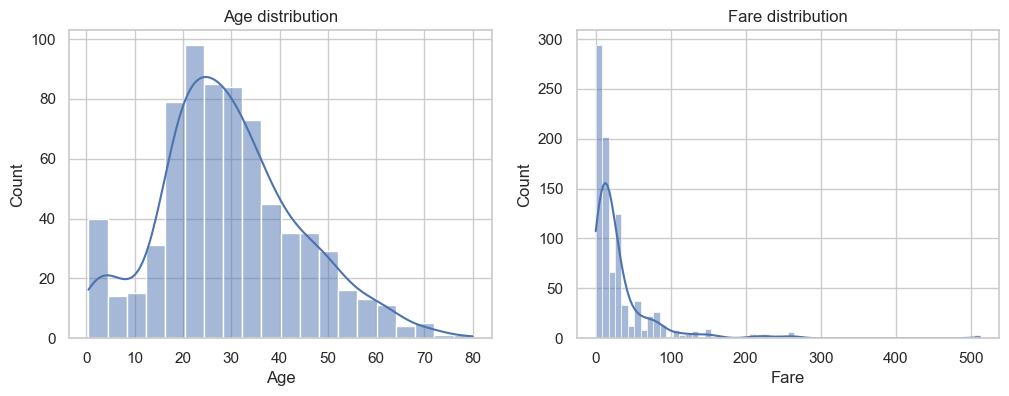

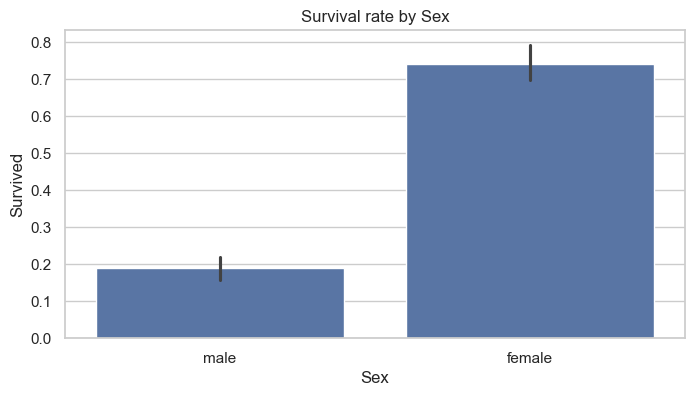

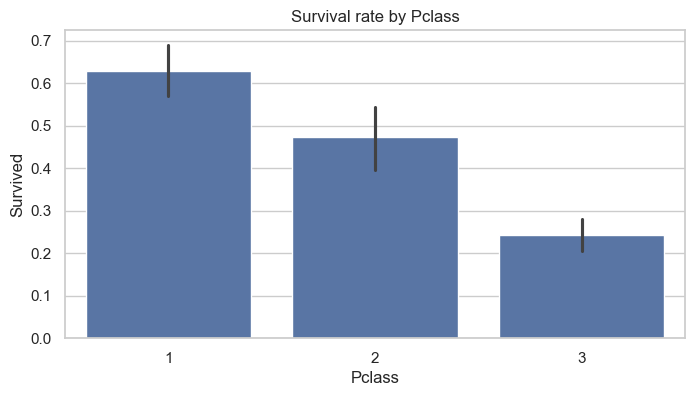

In [6]:
# Quick plots: Age and Fare distributions, survival by Sex and Pclass
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df['Age'].dropna(), kde=True)
plt.title('Age distribution')
plt.subplot(1,2,2)
sns.histplot(df['Fare'].dropna(), kde=True)
plt.title('Fare distribution')
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(x='Sex', y='Survived', data=df)
plt.title('Survival rate by Sex')
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(x='Pclass', y='Survived', data=df)
plt.title('Survival rate by Pclass')
plt.show()


In [21]:
# 4. Preprocessing: select features
features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
target = 'Survived'
df = df.copy()
df = df.loc[df[target].notna(), features + [target]]
X = df[features]
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
numeric_features = ['Age','SibSp','Parch','Fare']
categorical_features = ['Pclass','Sex','Embarked']


In [22]:
# Build preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])


In [23]:
# 5. Train model (with GridSearchCV to tune C)
param_grid = {
    'classifier__C': [0.01, 0.1, 1.0, 10]
}
search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
search.fit(X_train, y_train)
print('Best params:', search.best_params_)
best_model = search.best_estimator_


Best params: {'classifier__C': 1.0}


In [24]:
# Save model
joblib.dump(best_model, 'titanic_logreg_pipeline.joblib')
print('Saved model to titanic_logreg_pipeline.joblib')


Saved model to titanic_logreg_pipeline.joblib


Accuracy: 0.8045
Precision: 0.7931
Recall: 0.6667
F1-score: 0.7244
ROC AUC: 0.8427

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85       110
           1       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



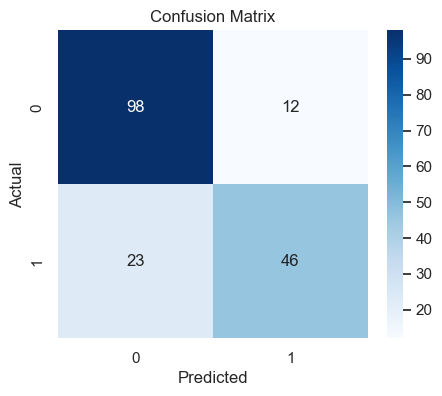

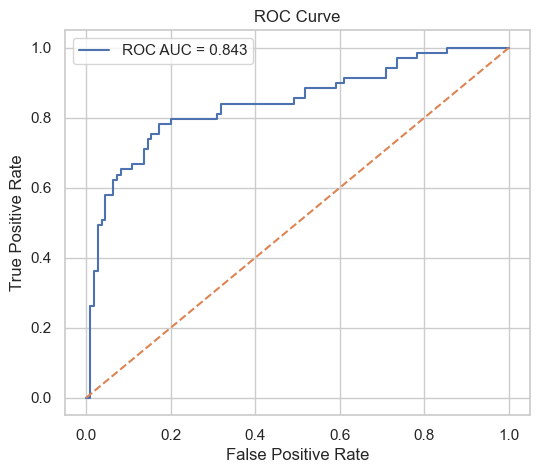

In [25]:
# 6. Evaluation
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

print('\nClassification Report:\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [26]:
# 7. Coefficients and interpretation
pre = best_model.named_steps['preprocessor']
ohe = pre.named_transformers_['cat'].named_steps['onehot']
num_names = numeric_features
cat_names = ohe.get_feature_names_out(categorical_features).tolist()
feature_names = num_names + cat_names
coefs = best_model.named_steps['classifier'].coef_[0]
coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
coef_df['odds_ratio'] = np.exp(coef_df['coef'])
coef_df = coef_df.sort_values(by='coef', ascending=False).reset_index(drop=True)
coef_df


,feature,coef,odds_ratio
0,Sex_female,1.364351,3.913184
1,Pclass_1,1.038653,2.825409
2,Embarked_Q,0.348068,1.416328
3,Pclass_2,0.138022,1.148001
4,Fare,0.133851,1.143223
5,Embarked_C,0.095733,1.100465
6,Parch,-0.070794,0.931654
7,SibSp,-0.261398,0.769975
8,Embarked_S,-0.321817,0.724831
9,Age,-0.489323,0.613041


# Streamlit code to run 

In [ ]:
# streamlit_app.py
import streamlit as st
import pandas as pd
import joblib
import os

from pathlib import Path
from io import BytesIO

st.set_page_config(page_title="Titanic Survival Predictor", layout="centered")
st.write("cwd:", os.getcwd())
st.write("files:", os.listdir())

MODEL_FILENAME = "titanic_logreg_pipeline.joblib"

@st.cache_resource
def load_model_from_path(path: Path):
    try:
        return joblib.load(path)
    except Exception as e:
        st.error(f"Failed to load model from disk: {e}")
        return None

@st.cache_resource
def load_model_from_bytes(b: BytesIO):
    try:
        b.seek(0)
        return joblib.load(b)
    except Exception as e:
        st.error(f"Failed to load uploaded model: {e}")
        return None

def build_input_df(pclass, sex, age, sibsp, parch, fare, embarked):
    return pd.DataFrame([{
        'pclass': pclass,
        'sex': sex,
        'age': age,
        'sibsp': sibsp,
        'parch': parch,
        'fare': fare,
        'embarked': embarked
    }])

def main():
    st.title("Titanic Survival Predictor (Logistic Regression)")
    st.write("Provide passenger features and click **Predict**. The app expects a scikit-learn pipeline saved with `joblib` that supports `.predict` and `.predict_proba` on a DataFrame with columns: Pclass, Sex, Age, SibSp, Parch, Fare, Embarked.")

    # Sidebar: model loader
    st.sidebar.header("Model")
    model = None
    if Path(MODEL_FILENAME).exists():
        st.sidebar.success(f"Found `{MODEL_FILENAME}` in this folder.")
        if st.sidebar.button("Load model from disk"):
            model = load_model_from_path(Path(MODEL_FILENAME))
    else:
        st.sidebar.info(f"No `{MODEL_FILENAME}` found in this folder.")

    uploaded = st.sidebar.file_uploader("Or upload a `.joblib` model file", type=["joblib"])
    if uploaded is not None:
        model = load_model_from_bytes(uploaded)

    if model is None:
        st.sidebar.warning("No model loaded. Upload or place a `.joblib` model file named `titanic_logreg_pipeline.joblib` in this folder, then press Load.")
        st.info("You can still try the UI, but Predict will show an error until a model is loaded.")
    else:
        st.sidebar.success("Model loaded ")

    # Input widgets
    col1, col2 = st.columns(2)
    with col1:
        pclass = st.selectbox("Pclass (1=1st, 2=2nd, 3=3rd)", options=[1, 2, 3], index=1)
        sex = st.selectbox("Sex", options=["male", "female"])
        age = st.number_input("Age (years)", min_value=0.0, max_value=120.0, value=30.0, step=0.5, format="%.1f")
        fare = st.number_input("Fare", min_value=0.0, max_value=10000.0, value=32.0, step=0.1, format="%.2f")
    with col2:
        sibsp = st.number_input("Siblings / Spouse aboard (SibSp)", min_value=0, max_value=10, value=0, step=1)
        parch = st.number_input("Parents / Children aboard (Parch)", min_value=0, max_value=10, value=0, step=1)
        embarked = st.selectbox("Port of Embarkation", options=["S", "C", "Q"])

    st.markdown("---")
    st.write("### Preview input")
    X_new = build_input_df(pclass, sex, age, sibsp, parch, fare, embarked)
    st.dataframe(X_new)

    if st.button("Predict Survival Probability"):
        if model is None:
            st.error("No model loaded. Upload or load a `joblib` model first (sidebar).")
            return

        try:
            proba = model.predict_proba(X_new)[0, 1]
        except Exception as e:
            st.error(f"Model does not support `predict_proba` with given input. Error: {e}")
            proba = None

        try:
            pred = model.predict(X_new)[0]
        except Exception as e:
            st.error(f"Model does not support `predict` with given input. Error: {e}")
            pred = None

        if proba is not None:
            st.success(f"Predicted probability of survival: **{proba:.3f}**")
        if pred is not None:
            st.write("Predicted class:", "**Survived**" if int(pred) == 1 else "**Did not survive**")

    st.markdown("---")
    st.caption("Tip: Save your scikit-learn pipeline with preprocessing and final estimator using `joblib.dump(pipeline, 'titanic_logreg_pipeline.joblib')`.")

if __name__ == "__main__":
    main()


Created streamlit_app.py in current folder.


# Interview Question & Answers

**1.Difference Between Precision and Recall?**

Precision measures how many of the predicted positive cases were truly positive.
- Formula: TP / (TP + FP).
- High precision means few false positives.

Recall measures how many of the actual positive cases were correctly identified.
- Formula: TP / (TP + FN).
- High recall means few false negativ

**2.What is cross-validation, and why is it important in binary classification?**

Cross-validation (CV) is a technique where the dataset is split into multiple folds (e.g., 5-fold).
The model is trained on some folds and tested on the remaining fold. This process repeats for all folds, and the results are averaged.

Why it is important:

- Gives a more reliable estimate of model performance than a single train/test split.

- Helps detect overfitting.

- Ensures the model generalizes well on unseen data.

- Very useful for hyperparameter tuning (e.g., regularization strength in Logistic Regression).

- Maintains class balance (using StratifiedKFold) which is crucial for binary classification.